# Predicting Antibiotic Resistance Using Genetic Sequences
James Eapen


Last update: 2020 May 21

## Vision
This project compares the effectiveness of different AI models at predicting whether a genetic sequence contains a gene that confers antibiotic resistance. The dataset is a collection of artificial genetic sequences labelled by whether or not it has a resistance gene. 

The model is based on an example by Scarlat of a binary classifier trained with convolutional and recurrent networks. Antibiotic resistance prediction is a growing field with active research and based on a review of machine learning methods, I will be adding a model with just a convolutional neural network, a random forest model, and a linear regression.

The goal of this project is to compare the different models and see what models perform the best. After initial runs of the neural networks and the random forest, I decided to compare runtimes as well since the random forest takes significantly less time to train than the neural networks. Understanding how models perform on genetic data is important for creating clinical models for antibiotic selection.




## Background

#### Antibiotic Resistance
Antibiotic resistance is a naturally occurring phenomenon that has been made worse by the human abuse of antibiotics. Antibiotics are compounds that interfere with bacterial metabolism and prevent normal functioning. They cure infections by killing the bacteria or by preventing its reproduction in the host. Every antibiotic has a mode of action that depends on it getting into and staying inside the bacterium and on structures within it that can be used to disrupt normal function. 

However, if a bacterium acquires a gene that changes a structure that the antibiotic disrupts, the antibiotic is no longer able to work. The gene could also work by coding for a pump that actively pumps the antibiotic if it enters the bacterium. A bacterium that has such a gene is said to be resistant to that antibiotic. If there are many such genes that render different antibiotics ineffective, the bacterium is a multi-drug resistant bacterium.

Studies of genomes have revealed the sequences that confer resistance and there are databases of known antibiotic resistance genes. Predicting whether a bacterium is resistant to an antibiotic from these sequences can help direct patients to the right antibiotic.

The features are artificial genomic sequences, made of four letter nucleotides A, C, G, and T. Groups of three nucleotides are called codons and each codon codes for a unit of a protein. The order in which they occur is important as it determines the structure and function of the protein it encodes. If there is a change in the order of nucleotides, it changes the codons which changes the protein produced by that gene. Sometimes this change results in a protein that protects the bacterium. This gene can be passed to others through reproduction and through transfer. 

#### New techonologies used in this project

A review by Su et al. examined the performance of a number of machine learning models on different antibiotics and bacteria. Random forests and logistic regressions were common models among the studies they reviewed.

Random forests work by creating a large number of decision trees based on information theory. The trees have little correlation between them and the learning process picks the trees with the best predictions allowing the trees to correct errors between them.

I will be using Keras for the neural networks, Numpy, and pandas for data manipulation and matplotlib for plotting accuracy scores. The random forest and logistic regression models will be implemented with the Scikit-learn package.

## Implementation

This implementation is based on the implementation by Scarlat on Kaggle that uses convolutional and bi-directional Gated Recurrent Unit networks. Both neural networks use two convolutional layers and one bi-directional GRU layer.  The first one tokenizes the genetic sequences into the raw nucleotides, A, C, G, and T. The second approach takes them in groups of three called codons that represent a unit of the protein the sequence codes for. 

I extended Scarlat's work by adding a random forest and a logistic regression and comparing the performances and runtimes of the four models. Since the codon approach was more successful than the raw nucleotide approach, I decided to build my models using the codon data.

This implementation section contains the model training and data collection. The collected data is presented in the results section where the predictions and the models' effectiveness is discussed.

In [0]:
# IMPORT MODULES

import os
import keras
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import time
%matplotlib inline

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

In [53]:
# IMPORT MODULES
# Load the dataset.npy

DataRaw = np.load('drive/My Drive/Colab Notebooks/dataset.npy', allow_pickle=True)
print(type(DataRaw))
print(DataRaw.ndim)
DataRaw

<class 'numpy.ndarray'>
0


array({'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTAC

In [54]:
# As a dictionary
Datadict = DataRaw[()]
print(Datadict)

# As a dataframe
DataDf = pd.DataFrame.from_dict(Datadict)
print(DataDf.shape)
DataDf

{'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTC

,resistant,genes
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...
3,False,ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATG...
4,False,ATGCACGACCGTATCATTCACTGGATGATGGAAATTGACTGCAATG...
...,...,...
99995,False,ATGCACTACCGTATGATTCACTGGATGATGGAAACTCTCTTTGACT...
99996,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
99997,True,ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTG...
99998,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAAT...


In [55]:
# Mean  / Max / Min column width

DataDf.fillna('').astype(str).apply(lambda x:x.str.len()).max()


resistant      5
genes        156
dtype: int64

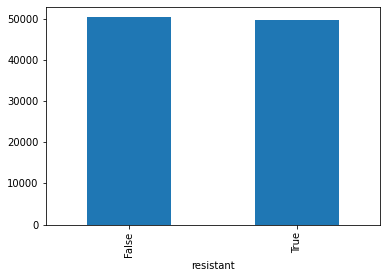

In [98]:
# Is the data balanced ?

DataDf.groupby('resistant').size().plot.bar()
plt.show()

Since the proportions of true and false labels are equal, there shouldn't be any bias from a imbalanced dataset.

In [56]:
# Tokenize from characters to integers (sequences and then pad / truncate data)

Datatok = DataDf.copy()
maxlen = 160 # cut off after this number of characters in a string

max_words = 4 # considers only the top number of characters in the dictionary A C T G
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer.fit_on_texts(list(Datatok['genes']))
sequences = tokenizer.texts_to_sequences(list(Datatok['genes']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(word_index))
print('word_index', word_index)

Found 4 unique tokens.
word_index {'a': 1, 't': 2, 'c': 3, 'g': 4}


In [57]:
# Separate the label

labels = np.asarray(Datatok['resistant'])
print(Xpad.shape)
print(labels.shape)

(100000, 160)
(100000,)


In [59]:
# Create train & val and test datasets with inital shuffle (as the original dataset may be arranged)

training_samples = int(Xpad.shape[0] * 0.9)

indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) 

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (90000, 160)
y_train (90000,)
x_test (10000, 160)
y_test (10000,)


In [60]:
model = Sequential()
model.add(Embedding(4, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(9))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 160, 1)            4         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 134, 128)          3584      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 6, 128)            147584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 128)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)               

In [61]:
# Train / Validate model
start_time = time.time()
history = model.fit(x_train, y_train,
epochs = 10,
batch_size=32,
validation_split=0.2)
nn1_runtime = time.time() - start_time
print("Runtime: %s seconds" % nn1_runtime)

Train on 72000 samples, validate on 18000 samples
Epoch 1/10
72000/72000 [==============================] - 91s 1ms/step - loss: 0.5965 - acc: 0.6415 - val_loss: 0.4771 - val_acc: 0.7352
Epoch 2/10
72000/72000 [==============================] - 87s 1ms/step - loss: 0.4862 - acc: 0.7278 - val_loss: 0.4409 - val_acc: 0.7728
Epoch 3/10
72000/72000 [==============================] - 87s 1ms/step - loss: 0.4439 - acc: 0.7537 - val_loss: 0.4051 - val_acc: 0.7764
Epoch 4/10
72000/72000 [==============================] - 88s 1ms/step - loss: 0.4263 - acc: 0.7634 - val_loss: 0.3896 - val_acc: 0.7885
Epoch 5/10
72000/72000 [==============================] - 89s 1ms/step - loss: 0.4136 - acc: 0.7684 - val_loss: 0.3889 - val_acc: 0.7929
Epoch 6/10
72000/72000 [==============================] - 89s 1ms/step - loss: 0.4052 - acc: 0.7739 - val_loss: 0.3904 - val_acc: 0.7818
Epoch 7/10
72000/72000 [==============================] - 88s 1ms/step - loss: 0.4014 - acc: 0.7747 - val_loss: 0.3770 - val_acc

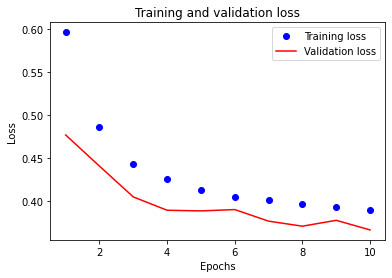

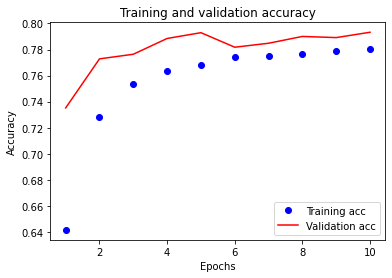

In [62]:
# Learning curves

# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The learning curves show that the model does better with increasing epochs until around epoch 8 and 9.

In [63]:
# Final Predict on test

final_predictions = model.predict(x_test)
print(final_predictions)

# Modify the raw final_predictions - prediction probs  - into 0 and 1
# Cutoff point = 0.5

Preds = final_predictions.copy()
print(len(Preds))

Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

[[5.0828528e-01]
 [5.1320922e-01]
 [9.9941516e-01]
 ...
 [4.7252762e-01]
 [9.8583102e-04]
 [2.9203570e-01]]
10000
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


This chunk generates the data to plot a confusion matrix and extract recall and precision information.

In [64]:
nn1_conf_mx = confusion_matrix(y_test, Preds)

TN = nn1_conf_mx[0,0]
FP = nn1_conf_mx[0,1]
FN = nn1_conf_mx[1,0]
TP = nn1_conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

nn1_recall = TP/(TP+FN)
nn1_precision = TP/(TP+FP)

TN:  4494
FP:  449
FN:  1628
TP:  3429


In [65]:
print ('precision ',precision_score(y_test, Preds))
print ('recall ',recall_score(y_test, Preds) )
print ('accuracy ',accuracy_score(y_test, Preds))
print ('F1 score ',f1_score(y_test, Preds))

precision  0.8842186694172254
recall  0.678070001977457
accuracy  0.7923
F1 score  0.7675433687744824


AUC: 0.794


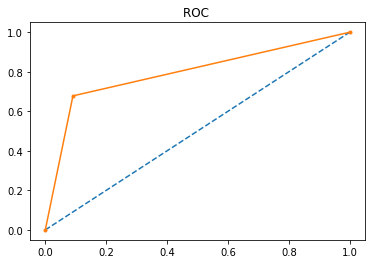

In [66]:
# calculate AUC
nn1_auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % nn1_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

### Codon Tokenization

In [73]:
# From nucleotides to codons ... w/o considering the start / stop codons as the data is synthetic and may not have these

DataCod = DataDf.copy()

Codons = list(DataCod['genes'])
print(len(Codons))

for n in range(len(Codons)):
    Codons[n] = list([Codons[n][i:i+3] for i in range(0, len(Codons[n]), 3)])
    
DataCod['codons'] = Codons
DataCod

100000


,resistant,genes,codons
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...,"[ATG, CAC, TAC, CGT, ATG, ATC, CCC, CTT, CAC, ..."
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATC, ..."
3,False,ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, GTG, ..."
4,False,ATGCACGACCGTATCATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, GAC, CGT, ATC, ATT, CAC, TGG, ATG, ..."
...,...,...,...
99995,False,ATGCACTACCGTATGATTCACTGGATGATGGAAACTCTCTTTGACT...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
99996,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
99997,True,ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
99998,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAAT...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."


In [74]:
# Tokenize from codons to integers (sequences and then pad / truncate data)

maxlen = 53 # cut off after this number of codons in a list

max_words = 64 # considers only the top number of codons  in the dictionary (It finds 66 below because of 'a' and 'ga')
max_features = max_words

#tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(DataCod['codons']))
sequences = tokenizer.texts_to_sequences(list(DataCod['codons']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(word_index))
print('word_index', word_index)

Found 66 unique tokens.
word_index {'cac': 1, 'cgt': 2, 'aat': 3, 'atg': 4, 'tac': 5, 'att': 6, 'tgg': 7, 'gac': 8, 'tgc': 9, 'act': 10, 'gtt': 11, 'gaa': 12, 'aaa': 13, 'cag': 14, 'tga': 15, 'ttg': 16, 'gct': 17, 'ttc': 18, 'tct': 19, 'ggc': 20, 'aca': 21, 'taa': 22, 'ctg': 23, 'ata': 24, 'caa': 25, 'ctt': 26, 'tcg': 27, 'gtc': 28, 'aac': 29, 'gga': 30, 'acg': 31, 'gca': 32, 'tta': 33, 'cta': 34, 'acc': 35, 'gat': 36, 'tca': 37, 'tat': 38, 'agg': 39, 'tgt': 40, 'gtg': 41, 'cga': 42, 'cgc': 43, 'ttt': 44, 'aga': 45, 'ggt': 46, 'ctc': 47, 'cca': 48, 'ccg': 49, 'gcg': 50, 'a': 51, 'ga': 52, 'tag': 53, 'atc': 54, 'cat': 55, 'agt': 56, 'cgg': 57, 'aag': 58, 'gag': 59, 'cct': 60, 'gta': 61, 'ggg': 62, 'tcc': 63, 'agc': 64, 'ccc': 65, 'gcc': 66}


In [75]:
# Separate the label

labels = np.asarray(DataCod['resistant'])
print(Xpad.shape)
print(labels.shape)

(100000, 53)
(100000,)


In [76]:
# Check a sample

rowNum = 37149
print(DataCod['genes'][rowNum])
print(DataCod['codons'][rowNum])
print(sequences[rowNum])
print(Xpad[rowNum])
print(labels[rowNum])

ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA
['ATG', 'CAC', 'TAC', 'CGT', 'ATG', 'ATT', 'CAC', 'TGG', 'ATG', 'ATG', 'GAA', 'ATT', 'GAC', 'TGC', 'AAT', 'GGC', 'TGC', 'GCT', 'AAT', 'AAT', 'ACT', 'TTG', 'TCT', 'CGT', 'CGT', 'TGG', 'AAT', 'TAC', 'GAC', 'TTC', 'TGG', 'CAC', 'AAA', 'CAC', 'GTT', 'GAA', 'CAG', 'GTT', 'AAA', 'TGC', 'TAC', 'CGT', 'CAC', 'AAT', 'ATT', 'CGT', 'GAC', 'CAG', 'ACT', 'TGA']
[4, 1, 5, 2, 4, 6, 1, 7, 4, 4, 12, 6, 8, 9, 3, 20, 9, 17, 3, 3, 10, 16, 19, 2, 2, 7, 3, 5, 8, 18, 7, 1, 13, 1, 11, 12, 14, 11, 13, 9, 5, 2, 1, 3, 6, 2, 8, 14, 10, 15]
[ 4  1  5  2  4  6  1  7  4  4 12  6  8  9  3 20  9 17  3  3 10 16 19  2
  2  7  3  5  8 18  7  1 13  1 11 12 14 11 13  9  5  2  1  3  6  2  8 14
 10 15  0  0  0]
True


In [77]:
# Create train & val and test datasets with inital shuffle (as the original dataset may be arranged)

training_samples = int(Xpad.shape[0] * 0.9)
# The validation is being taken by keras - below
# test = remaining

indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) # FOR TESTING PURPOSES comment it out - to keep indices as above

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (90000, 53)
y_train (90000,)
x_test (10000, 53)
y_test (10000,)


In [20]:
# Model ... 64 CNN window 27 & Bidirectional GRU accuracy = 0.99

model = Sequential()
model.add(Embedding(64, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 1)             64        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           3584      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 128)            147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)               

In [21]:
# Train / Validate model
start_time = time.time()
history = model.fit(x_train, y_train,
epochs = 10,
batch_size=32,
validation_split=0.2)
nn2_runtime = time.time() - start_time
print("Runtime: %s seconds" % nn2_runtime)

Train on 72000 samples, validate on 18000 samples
Epoch 1/10
72000/72000 [==============================] - 45s 620us/step - loss: 0.1078 - acc: 0.9505 - val_loss: 0.0431 - val_acc: 0.9882
Epoch 2/10
72000/72000 [==============================] - 43s 594us/step - loss: 0.0406 - acc: 0.9885 - val_loss: 0.0377 - val_acc: 0.9882
Epoch 3/10
72000/72000 [==============================] - 43s 594us/step - loss: 0.0395 - acc: 0.9885 - val_loss: 0.0374 - val_acc: 0.9882
Epoch 4/10
72000/72000 [==============================] - 43s 596us/step - loss: 0.0383 - acc: 0.9886 - val_loss: 0.0388 - val_acc: 0.9882
Epoch 5/10
72000/72000 [==============================] - 43s 603us/step - loss: 0.0381 - acc: 0.9885 - val_loss: 0.0374 - val_acc: 0.9881
Epoch 6/10
72000/72000 [==============================] - 43s 601us/step - loss: 0.0374 - acc: 0.9885 - val_loss: 0.0475 - val_acc: 0.9882
Epoch 7/10
72000/72000 [==============================] - 43s 598us/step - loss: 0.0375 - acc: 0.9884 - val_loss: 0.

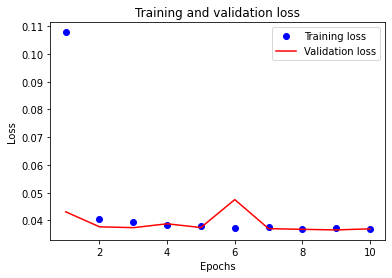

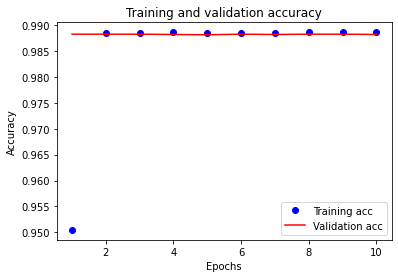

In [22]:
# Learning curves

# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# Final Predict on test

final_predictions = model.predict(x_test)
print(final_predictions)

# Modify the raw final_predictions - prediction probs  - into 0 and 1
# Cutoff point = 0.5

Preds = final_predictions.copy()
print(len(Preds))

Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

[[9.9985236e-01]
 [9.9985236e-01]
 [7.0381531e-05]
 ...
 [9.9985278e-01]
 [7.6145880e-05]
 [9.9985278e-01]]
10000
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [1.]]


In [0]:
# Confusion matrix, precision and recall

nn2_conf_mx = confusion_matrix(y_test, Preds)

TN = nn2_conf_mx[0,0]
FP = nn2_conf_mx[0,1]
FN = nn2_conf_mx[1,0]
TP = nn2_conf_mx[1,1]

nn2_recall = TP/(TP+FN)
nn2_precision = TP/(TP+FP)

AUC: 0.987


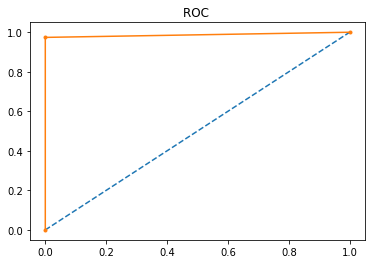

In [25]:
# calculate AUC
nn2_auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % nn2_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

## Extension: Random Forest Classifier

This random forest classifier creates 100 decision trees that use entropy during the training phase. I ran tress with more decision trees, but that led to overfitting and reduced testing scores.


In [87]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [88]:
start_time = time.time()
rf = rf.fit(x_train, y_train)
rf_runtime = time.time() - start_time
print("Runtime: %s seconds" % rf_runtime)

Runtime: 6.241521596908569 seconds


In [89]:
rf_Preds = rf.predict(x_test)
print("Test accuracy score: ", accuracy_score(y_test, rf_Preds))


Test accuracy score:  0.9901


In [0]:
# Confusion matrix

rf_conf_mx = confusion_matrix(y_test, rf_Preds)

TN = rf_conf_mx[0,0]
FP = rf_conf_mx[0,1]
FN = rf_conf_mx[1,0]
TP = rf_conf_mx[1,1]

rf_recall = TP/(TP+FN)
rf_precision = TP/(TP+FP)

AUC: 0.990


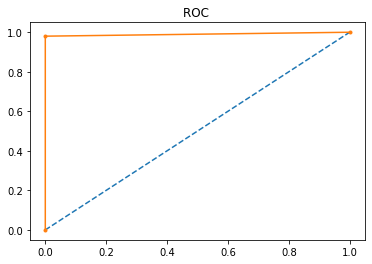

In [91]:
# calculate AUC
rf_auc = roc_auc_score(y_test, rf_Preds)
print('AUC: %.3f' % rf_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, rf_Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

## Extension: Logistic Regression

A logistic regression is used to fit a model that has binary labels. A linear regression could be used as well, but it is not as suited to binary data as a logistic regression.

In [78]:
logistic_reg = LogisticRegression(max_iter=5000)
start_time = time.time()
logistic_reg.fit(x_train, y_train)
lg_runtime = time.time() - start_time
lg_runtime

42.806254863739014

In [79]:
lg_Preds = logistic_reg.predict(x_test)
lg_score = logistic_reg.score(x_test, y_test)
print("Logistic Regression score: ", lg_score)

Logistic Regression score:  0.9174


In [0]:
lg_conf_mx = confusion_matrix(y_test, lg_Preds)

TN = lg_conf_mx[0,0]
FP = lg_conf_mx[0,1]
FN = lg_conf_mx[1,0]
TP = lg_conf_mx[1,1]

lg_recall = TP/(TP+FN)
lg_precision = TP/(TP+FP)

AUC: 0.917


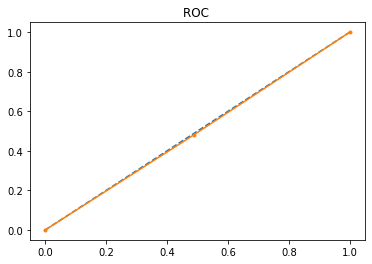

In [81]:
# calculate AUC
lg_auc = roc_auc_score(y_test, lg_Preds)
print('AUC: %.3f' % lg_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, rf_Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

## Results
#### AUC

The AUC value represents how well the model is able to distinguish between the true and false labels. A value closer to 1 indicates a high capacity to separate them while values closer to 0 indicate a low capacity to make good predictions

The nucleotide based neural network had an AUC of 0.79 while the codon based model had more success than the raw nucleotide based model with an AUC value of 0.99. It was able to 

The random forest had an AUC value of 0.989 which is equivalent to that of the second neural network. Some runs of this notebook had the random forest performing better than the neural network.

The Logistic regression was in between the first NN and the second with an AUC of 0.92. 

Model 					 AUC 
----------------------------------------------------------
Nucleotide based neural network: 	 0.7936172384963149
Codon based neural network: 		 0.9869765578040472
Codon based random forest: 		 0.990074192901544
Codon based logistic regression: 	 0.9172923208960893


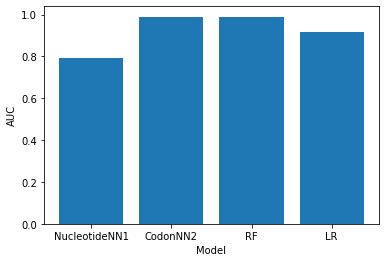

In [100]:
print("Model \t\t\t\t\t AUC ")
print("----------------------------------------------------------")
print("Nucleotide based neural network: \t", nn1_auc)
print("Codon based neural network: \t\t", nn2_auc)
print("Codon based random forest: \t\t", rf_auc)
print("Codon based logistic regression: \t", lg_auc)

aucs = [nn1_auc, nn2_auc, rf_auc, lg_auc]
plt.bar(["NucleotideNN1", "CodonNN2", "RF", "LR"], aucs)
plt.xlabel("Model")
plt.ylabel("AUC")
plt.show()

#### Confusion Matrices
A confusion matrix can be used to see how well the model is making its predictions by visualizing the true and false positives and negatives. This is useful because a false negative prediction can be clinically more damaging than a false positive prediction since it is worse to take ineffective action against an antibiotic resistant bacterium than to take an intensive treatment against a susceptible bacterium. Seeing the four possibilities provides more insight into a model's usefulness than just an accuracy score. 


In [0]:
# Function to visualize the confusion matrix for results

def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### Nucleotide based model

This model had an accuracy of 0.79 with 449 false negatives and 1628 false positives. This is not a very useful model because of such a high false negative rate. 

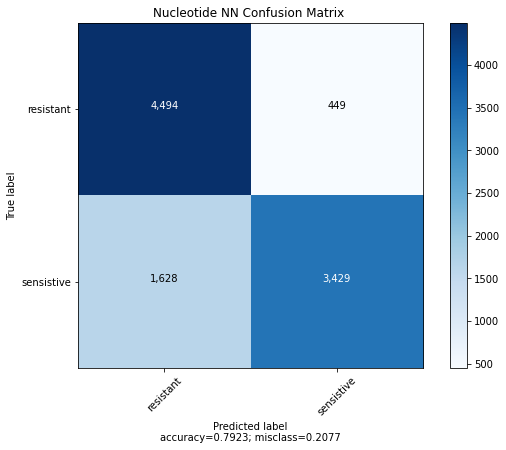

In [101]:
plot_confusion_matrix(nn1_conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Nucleotide NN Confusion Matrix ")

#### Codon based neural network

This model does quite well in testing as it has no false negatives and 130 false positives giving it an accuracy of 0.985. Some runs had a couple of false negatives. This model would be more clinically useful and with some more tweaking, could eliminate the false negative predictions.

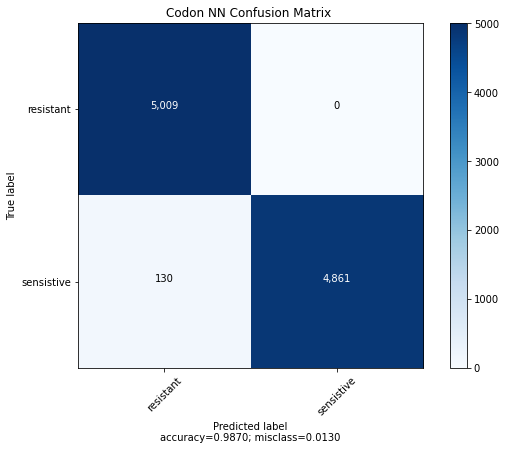

In [102]:
plot_confusion_matrix(nn2_conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Codon NN Confusion Matrix ")

#### Random forest using codon tokens

With 0 false negatives this model is better than the neural network above. It has fewer false positives and an almost equivalent accuracy score of 0.9894. Usually, it had as many or a few more false negatives than the codon-based neural network. However, for its runtime, it gets exceptional results.

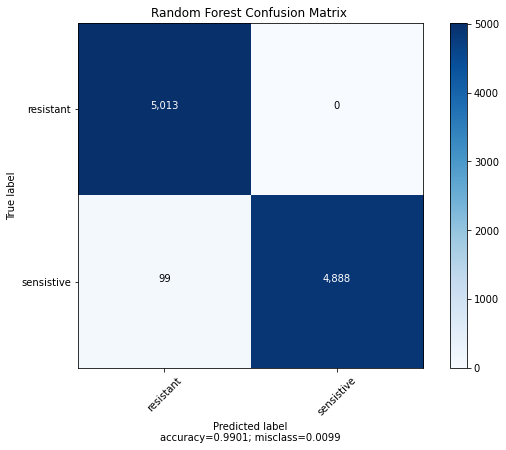

In [103]:
plot_confusion_matrix(rf_conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Random Forest Confusion Matrix ")

#### Logistic Regression

The logistic regression had 210 false negatives and 641 false positives. This is better than the raw nucleotide based neural net, but would be be very useful in practice. The random forest runs in less time and gets fewer false negatives.

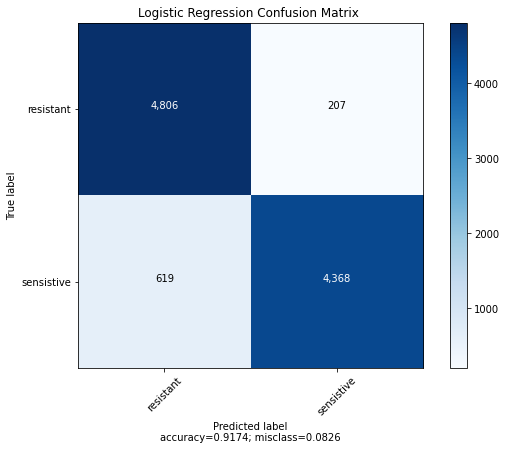

In [104]:
plot_confusion_matrix(lg_conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Logistic Regression Confusion Matrix ")


### Runtimes


Model 				Time(seconds) 		Time(mininutes)
-----------------------------------------------------------------------------------------
Nucleotide neural network: 	851.081878900528	14.184697981675466 
Codon neural network:  		440.0965759754181	7.334942932923635 
Codon random forest:  		8.222691774368286 	0.1370448629061381 
Codon logisitc regression:  	44.152079820632935 	0.735867997010549 


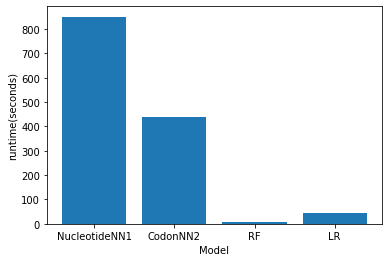

In [42]:
print("Model \t\t\t\tTime(seconds) \t\tTime(mininutes)")
print("-----------------------------------------------------------------------------------------")
print("Nucleotide neural network: \t{0}\t{1} ".format(nn1_runtime, nn1_runtime/60))
print("Codon neural network:  \t\t{0}\t{1} ".format(nn2_runtime, nn2_runtime/60))
print("Codon random forest:  \t\t{0} \t{1} ".format(rf_runtime, rf_runtime/60))
print("Codon logisitc regression:  \t{0} \t{1} ".format(lg_runtime, lg_runtime/60))

runtimes = [nn1_runtime, nn2_runtime, rf_runtime, lg_runtime]
plt.bar(["NucleotideNN1", "CodonNN2", "RF", "LR"], runtimes)
plt.xlabel("Model")
plt.ylabel("runtime(seconds)")
plt.show()

The training runtimes of the models did not seem to be correlated with their quality. 

The nucleotide neural network took the longest time to run, but was the poorest model while the random forest took less than 10 seconds and was either almost as good as the codon trained neural network or better. The logistic regression look less than a minute, but was still not as good as the random forest in its recall.



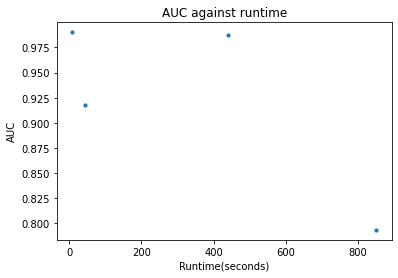

In [97]:
area = 10

plt.scatter(runtimes, aucs, s = area)
plt.title("AUC against runtime")
plt.xlabel("Runtime(seconds)")
plt.ylabel("AUC")
plt.show()

## Implications

From this study, I learned that the selection of the feature is the most important part of the model. Selecting nucleotides, even though they are the basic blocks of a gene, did not provide as good a model as selecting codons that are a higher level feature. This shows that while nucleotides make up genes, it is the codon groups that provide the sequence with meaning and function and are the basic unit when trying to understand the sequence.

This also agrees with the science behind mutations as many mutations are harmless when they are substitutions of nucleotides. However, when there is a deletion, the resulting frame shift causes a much more significant difference in the protein structure. The impact of a frame shift is more evident in an examination of the codons because every codon changes with an addition or deletion. On the other hand, examining the nucleotides is less revealing as most of the nucleotide sequence is largely unchanged.

Neural networks and random forests are useful tools in predicting the presence of antibiotic resistance genes in a given sequence. Random forests are particularly useful for preliminary analyses that are both quick to train and quite robust. These ensembles may be used to guide the training of better neural network models that can be trained for longer to achieve more reliable and clinically applicable results.  

While this dataset was a small synthetic one and may have been easy to work with, Whole Genome Sequencing is on the rise in which a full genome is analylzed. This will be harder to analyze and predict from  and the chances of false negatives will be higher as new mutations arise that confer bacteria with novel resistance mechanisms. According to Su et al., it is slow and expensive to create such models and this prevents a more widespread use of predictive software in clinical microbiology. 

The ability to predict antibiotic resistance from genomic data will be an asset to fighting infections and antibiotic resistant bacteria. The CDC estimates that in the US, at least two million people will contract a drug-resistant infection with 23,000 of them dying each year (Centers for Disease Control, 2013). Continued research in this area is critical because being able to predict resistance will allow for the timely selection of the right kinds of antibiotics, reducing the death rate from such infections. 


## Citations

Centers for Disease Control and Prevention. 2013. Antibiotic resistance threats in the United States. Centers for Disease Control and Prevention, Atlanta, GA. https://www.cdc.gov/drugresistance/pdf/ar-threats-2013-508.pdf.

Scarlat, Alexander, Predict antibiotic resistance w gene sequence, Kaggle. https://www.kaggle.com/drscarlat/predict-antibiotic-resistance-w-gene-sequence/data

Su, M., Satola, S. W., & Read, T. D. (2019). Genome-Based Prediction of Bacterial Antibiotic Resistance. Journal of clinical microbiology, 57(3), e01405-18. https://doi.org/10.1128/JCM.01405-18